# Optimizing Conversion Rates

This notebook details the approaches and the recommendations of Project Outreach which aims to optimize conversion rates for a website.


<b>This notebook covers:</b>
1. Data Cleaning
2. Data Exploration
3. Model Building
3. Recommendations

<b>Approach:</b>
1. Our approach is once we cleaned the data we use a classification model as a feature significance tool. 
2. Once we are able to narrow down to the most descriptive features, we do deep dives into these features and extract exact recommendations for each feature where we could optimize the conversion.


<b> Recommendations:</b>
1. The number of pages that a user sees is incredibly predictive of the conversion rate, so the website's focus should be increasing the likelihood that a user will see another page. 
2. More specifically, the # of pages that will significantly increase conversion is 9 - 15 pages where we get the most  gains on the conversion rate. 
3. Create incentives within the site for the user to keep clicking and to engage with the site. Do sweepstakes, promos, sales, etc.
4. Investigate why there were 2 data points with users that had ages of over 100 years. 


<b> Next Steps:</b>
1. I would be interested in getting more granular data on a user's path throughout the website. Maybe there are certain pages that convert users more than others. Doing an analysis of the sequence of interactions of a user will allow for a deeper understanding of what makes people convert. 

### Aside from that, I hope you enjoy this notebook!

In [317]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

In [318]:
# Make all my plots 538 Style
plt.style.use('fivethirtyeight')

In [319]:
#download data
df = pd.read_csv('conversion_data.csv')
# see columns
df.head()

country  age  new_user source  total_pages_visited  converted
0      UK   25         1    Ads                    1          0
1      US   23         1    Seo                    5          0
2      US   28         1    Seo                    4          0
3   China   39         1    Seo                    5          0
4      US   30         1    Seo                    6          0

# a. Exploring the Data 

In [320]:
df.shape

(316200, 6)

In [321]:
# 3% Conversion Rate
df.converted.sum()/float(df.converted.count())

0.032258064516129031

As of now it has a 3% conversion rate, we'll try to increase this by finding the most important feature. 

### Get Feature Distributions

123


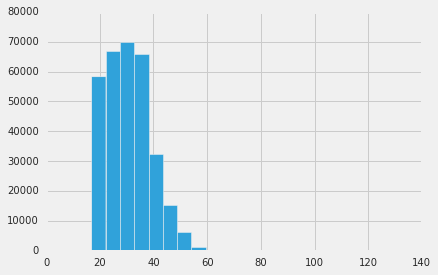

In [322]:
# There is at least 1 outlier
df.age.hist(bins=20)
print df.age.max()

User base looks pretty young but there is someone with 123 years old! <br>
Lets investigate this outlier

In [323]:
df[df.age >= 80]

country  age  new_user source  total_pages_visited  converted
90928   Germany  123         0    Seo                   15          1
295581       UK  111         0    Ads                   10          1

There are two people over 100 years! <br>
Lets remove these rows

In [324]:
df = df[df.age <= 80].copy()

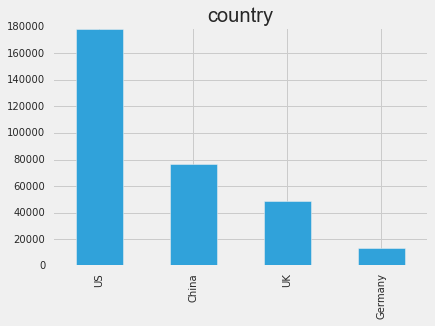

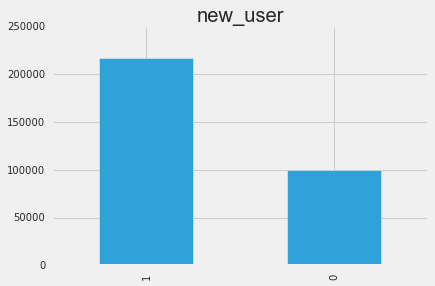

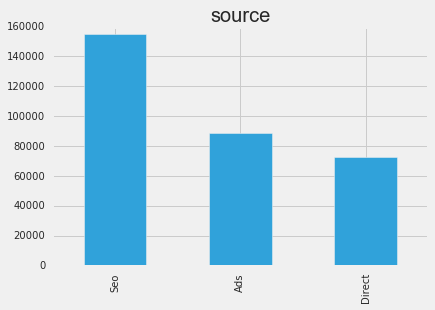

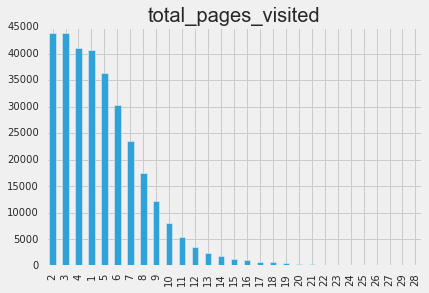

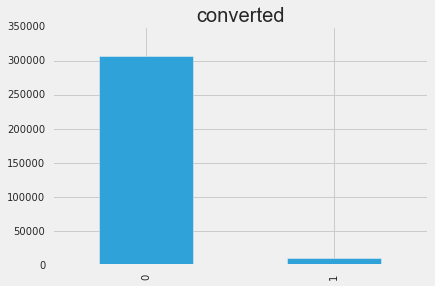

In [206]:
# Create a Loop To Print Out All Distributions
for i in [i for i in df.columns if i != 'age']:
    df[i].value_counts().plot(kind = 'bar')
    plt.title(i)
    plt.show()

Things to Notice: <br>
1. Most of the traffic comes from the U.S.
2. The vast majority of people only view a couple of pages visited. 

## Get A Conversion Rate By Country

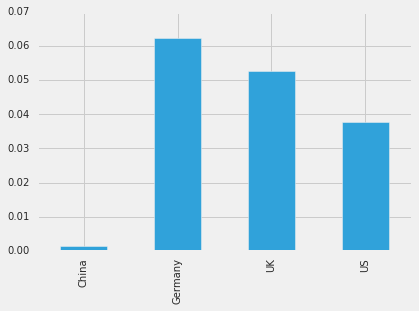

In [329]:
(df.groupby('country').sum()['converted']/df.country.value_counts()).plot(kind = 'bar')

China doesn't convert!

# b. Creating a Descriptive Model

In [331]:
# Creating dummy variables
dums = pd.get_dummies(df[['source', 'country']])

In [332]:
# Seperating the Dependent and independent variables
X = pd.concat([dums, df[['age', 'new_user', 'total_pages_visited']]], axis = 1)
y = df.converted

In [333]:
# Creating a train and test split
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [334]:
# Training the model
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(criterion = 'entropy')
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [335]:
# See if the features are descriptive at all
prediction = rf.predict(X_test)
f1_score(y_test, prediction )

0.73781376518218622

From this f1 score we see that the features are predictive of someone converting. 

<b> Rank the Feature Significance of the Features

[ 0.002092    0.00238075  0.00261024  0.04712732  0.00222146  0.00376365
  0.0043853   0.11398961  0.06425791  0.75717176]


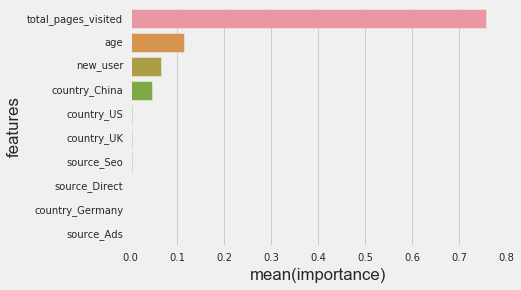

In [336]:
test = pd.DataFrame({'features': X.columns, 'importance': rf.feature_importances_})\
                    .sort_values('importance', ascending= False)
print rf.feature_importances_
sns.barplot(x = 'importance', y = 'features', data = test.head(10), orient='h')

## c. Investigate Total Pages Visited (The Most Descriptive Feature)

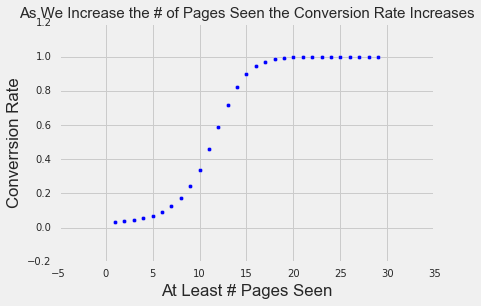

In [337]:
percent_converted = []
for i in np.sort(list(set(df.total_pages_visited))):
    x = df[df.total_pages_visited>= i].converted.value_counts()
    percent_converted.append(x.loc[1]/float(x.sum()))
plt.scatter(np.sort(list(set(df.total_pages_visited))), percent_converted )
plt.xlabel('At Least # Pages Seen')
plt.ylabel('Converrsion Rate')
plt.title('As We Increase the # of Pages Seen the Conversion Rate Increases', size = 15)

There is clearly a strong correlation between the # of pages seen and the conversion rate. <br>

It however, has diminishing returns. <br>
With the most incremental gains from 9 - 15 pages. <br>

<b> Recommendation: </b><br>
- Get users to browse at least 9 pages, any page after that will significanly increase the conversion rate. 


<b> Possible Limitations:  </b> <br>
- The # of pages seen could be something we have limited control of since that could be correlated with users that come in that browsing things they want. 

<b> Next Steps:  </b> <br>
- See the second most descriptive feature, although it may not have as predictive we may have more control of that lever. 


# d. Investigating the Other Features

In [338]:
# Seperating the Dependent and independent variables
X = pd.concat([dums, df[['age', 'new_user']]], axis = 1)
y = df.converted

# Creating a train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Training the model
rf = RandomForestClassifier(criterion = 'entropy')
rf.fit(X_train,y_train)

# See if the features are descriptive at all
prediction = rf.predict(X_test)
f1_score(y_test, prediction )

0.0

In [339]:
confusion_matrix(y_test, prediction )

array([[101029,      0],
       [  3317,      0]])

Without the the # of pages seen the model is not descriptive at all, <br>
meaning that the other features are not as descriptive. 